In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy as sp
import matplotlib.gridspec as gridspec
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch
import time
from tabulate import tabulate

import sys 
sys.path.append("../src/unicycleSourceFiles")
import importlib
import models
import unicycle
import config
import trainer
import utils
importlib.reload(models)
importlib.reload(unicycle)
importlib.reload(config)
importlib.reload(trainer)
importlib.reload(utils)
from models import DeepONetProjected, FNOProjected, FNOGRUNet, DeepONetGRUNet, ml_predictor
from unicycle import simulate_system_const_delay, predictor_const_delay
from config import ModelConfig, SimulationConfig
from trainer import model_trainer, evaluate_train_performance, evaluate_model    
from utils import plot_trajectory, count_parameters, plot_trajectory_with_errors

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

#### Build general simulation settings configs

In [3]:
dynamics_config = {
    "T": 10, # Simulation final time
    "dt": 0.01, # Simulation step size
    "D": 1, # Delay length
    "dx": 0.01 # Simulation for propagating the transport PDE
}

dataset_config = {
    "batch_size": 32,  # batch_size
    "test_size": 0.1, # Percentage of data to use for testing
    "random_state": 1, # random state for train test split
    "device_name": "cuda" # Use cuda or CPU
}

sim_config = SimulationConfig({"dynamics": dynamics_config, "dataset": dataset_config})

#### Build a dataset
(optional) Can load a dataset from hugging face

In [4]:
# # build a dataset for unicycle for const delay. Vary over both initial conditions and delay
# num_trajs = 100
# sample_rate = 200
# dt = sim_config.dt
# T = sim_config.T
# D = sim_config.D
# dx = sim_config.dx
# x = sim_config.x
# nx = len(x)
# t = sim_config.t
# nt = len(t)
# index = 0

# inputs = np.zeros((num_trajs*sample_rate, nx, 6))
# outputs = np.zeros((num_trajs*sample_rate, nx, 3))
# for i in range(num_trajs):
#     if i % 5 == 0:
#         print(i)
#     # CONTROLS THE INITAL CONDITION AND DEVIATION TO BUILD DATASET
#     init_cond = np.array([1, 1, 1]) + np.random.uniform(-0.2, 0.2, size=3)
#     # CONTROLS THE DELAY DEVIATION
#     D = np.random.uniform(1, 1.1)
#     u_delay, control_delay, pde, predictions = simulate_system_const_delay(init_cond, dt, T, dx, D, predictor_const_delay, None)
#     sample_locs = random.sample(range(0, nt), sample_rate)
#     for sample in sample_locs:
#         delays = np.full(nx, D).reshape(nx, 1)
#         states = np.tile(u_delay[sample], (nx, 1))
#         inputs[index] = np.hstack([delays, states, pde[sample]])
#         outputs[index] = predictions[sample]
#         index += 1

# np.save('../datasets/UnicycleConstDelayDataset/inp_dataset_const.npy', inputs)
# np.save('../datasets/UnicycleConstDelayDataset/out_dataset_const.npy', outputs)

#### Load model configs

In [5]:
# Configure FNO
train_config_fno = {
    "model_filename": "fno", # File to save/load trained model
    "model_type": "FNO",  # Specifies what model we are loading
    "epochs": 100,  # Specifies the number of epochs to train model
    "gamma": 0.93, # Specifies the learning rate scheduling parameter
    "learning_rate": 1e-3, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_fno = {
    "hidden_size": 16, # Specifies number of neurons per layer
    "modes": 12, # Specifies number of fourier nodes to use
    "num_layers": 2, # Specifies number of layers
}

fno_config = ModelConfig({"train": train_config_fno, "FNO": architecture_config_fno})

# Build archtiecture.
fno_config.update_config(input_channel=6, output_channel=3)
fno = FNOProjected(fno_config.hidden_size, fno_config.num_layers, fno_config.modes, fno_config.input_channel, fno_config.output_channel)

In [6]:
# Configure DeepONet
train_config_deeponet = {
    "model_filename": "deeponet", # File to save/load trained model
    "model_type": "DeepONet",  # Specifies what model we are loading
    "epochs": 100,  # Specifies the number of epochs to train model
    "gamma": 0.93, # Specifies the learning rate scheduling parameter
    "learning_rate": 1e-3, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_deeponet = {
    "hidden_size": 32, # Specifies number of neurons per layer
    "num_layers": 3, # Specifies number of layers,
    "dim_x": 1, # Specifies the input dimension,
}

deeponet_config = ModelConfig({"train": train_config_deeponet, "DeepONet": architecture_config_deeponet})
deeponet_grid = np.arange(0, sim_config.D, sim_config.dx/6).astype(np.float32)
deeponet_grid = torch.from_numpy(deeponet_grid.reshape((len(deeponet_grid), 1))).to(sim_config.device)
deeponet_config.update_config(input_channel=deeponet_grid.shape[0], output_channel=len(sim_config.x)*3)
deeponet = DeepONetProjected(deeponet_config.dim_x, deeponet_config.hidden_size, deeponet_config.num_layers, \
                            deeponet_config.input_channel, deeponet_config.output_channel, \
                            deeponet_grid)

In [7]:
# Configure FNO GRU
train_config_fno_gru = {
    "model_filename": "fnogru", # File to save/load trained modelTry this:
    "model_type": "FNO+GRU",  # Specifies what model we are loading
    "epochs": 100,  # Specifies the number of epochs to train model
    "gamma": 0.9, # Specifies the learning rate scheduling parameter
    "learning_rate": 8e-4, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_fno_gru = {
    "fno_hidden_size": 16, # Specifies number of neurons per layer FNO
    "modes": 12, # Specifies number of fourier nodes to use
    "fno_num_layers": 2, # Specifies number of layers FNO
    "gru_hidden_size": 32, # Specifies number of neurons per layer GRU
    "gru_num_layers": 3
}

fno_gru_config = ModelConfig({"train": train_config_fno_gru, "FNOGRU": architecture_config_fno_gru})

# Build architecture. Note that input and output channels depend on DOF chosen and so we update here.
fno_gru_config.update_config(input_channel=6, output_channel=3)
fno_gru = FNOGRUNet(fno_gru_config.fno_num_layers, fno_gru_config.gru_num_layers, fno_gru_config.fno_hidden_size, \
          fno_gru_config.gru_hidden_size, fno_gru_config.modes, fno_gru_config.input_channel, \
          fno_gru_config.output_channel)

In [8]:
# Configure DeepONet GRU
train_config_deeponet_gru = {
    "model_filename": "deeponetgru", # File to save/load trained model
    "model_type": "DeepONet+GRU",  # Specifies what model we are loading
    "epochs": 100,  # Specifies the number of epochs to train model
    "gamma": 0.93, # Specifies the learning rate scheduling parameter
    "learning_rate": 5e-4, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_deeponet_gru = {
    "deeponet_hidden_size": 32, # Specifies number of neurons per layer
    "deeponet_num_layers": 3, # Specifies number of layers,
    "dim_x": 1, # Specifies the input dimension,
    "gru_num_layers": 3, 
    "gru_hidden_size": 32,
}

deeponet_gru_config = ModelConfig({"train": train_config_deeponet_gru, "DeepONetGRU": architecture_config_deeponet_gru})

# Build archtiecture. Note that input and output channels depend on DOF chosen and so we update here.
deeponet_gru_grid = np.arange(0, sim_config.D, sim_config.dx/6).astype(np.float32)
deeponet_gru_grid = torch.from_numpy(deeponet_gru_grid.reshape((len(deeponet_gru_grid), 1))).to(sim_config.device)
deeponet_gru_config.update_config(input_channel=deeponet_gru_grid.shape[0], output_channel=len(sim_config.x)*3)
deeponet_gru = DeepONetGRUNet(deeponet_gru_config.dim_x, deeponet_gru_config.deeponet_num_layers, deeponet_gru_config.gru_num_layers, \
                         deeponet_gru_config.deeponet_hidden_size, deeponet_gru_config.gru_hidden_size, deeponet_gru_config.input_channel, \
                         deeponet_gru_config.output_channel, deeponet_gru_grid)

In [9]:
print(f"{'Model':<15} {'Number of parameters':<20}")
print(f"{'FNO':<15} {count_parameters(fno):<12}")
print(f"{'DeepONet':<15} {count_parameters(deeponet):<12}")
print(f"{'FNO GRU':<15} {count_parameters(fno_gru):<12}")
print(f"{'DeepONet GRU':<15} {count_parameters(deeponet_gru):<12}")

Model           Number of parameters
FNO             7171        
DeepONet        1102909     
FNO GRU         22470       
DeepONet GRU    1119232     


### Train our models
(Optional) Models can be downloaded from hugging face. Should be fast for unicycle problem with a GPU.
Uncomment below to train. May need to be careful with memory and release kernel memory between each train. 

In [10]:
# Prepare dataset
inputs = np.load("../datasets/UnicycleConstDelayDataset/inp_dataset_const.npy").astype(np.float32)
outputs = np.load("../datasets/UnicycleConstDelayDataset/out_dataset_const.npy").astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=sim_config.test_size, random_state=sim_config.random_state)
x_train = torch.from_numpy(x_train).to(sim_config.device)
x_test = torch.from_numpy(x_test).to(sim_config.device)
y_train = torch.from_numpy(y_train).to(sim_config.device)
y_test = torch.from_numpy(y_test).to(sim_config.device)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=sim_config.batch_size, shuffle=True, generator=torch.Generator(device=sim_config.device))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=sim_config.batch_size, shuffle=False, generator=torch.Generator(device=sim_config.device))

In [12]:
# # Train FNO
# fno, fno_train_loss_arr, fno_test_loss_arr = model_trainer(fno, trainData, testData, \
#                                                          fno_config.epochs, sim_config.batch_size, \
#                                                          fno_config.gamma, fno_config.learning_rate,\
#                                                          fno_config.weight_decay,\
#                                                          "../models/UnicycleConstDelayModels/fno")
# evaluate_train_performance(fno, fno_config.model_type, fno_train_loss_arr, fno_test_loss_arr)

In [13]:
# # Train DeepONet
# deeponet, deeponet_train_loss_arr, deeponet_test_loss_arr = model_trainer(deeponet, trainData, testData, \
#                                                          deeponet_config.epochs, sim_config.batch_size, \
#                                                          deeponet_config.gamma, deeponet_config.learning_rate,\
#                                                          deeponet_config.weight_decay,\
#                                                          "../models/UnicycleConstDelayModels/deeponet")
# evaluate_train_performance(deeponet, deeponet_config.model_type, deeponet_train_loss_arr, deeponet_test_loss_arr)

Epoch Time Train Loss Test Loss
Total epochs 100
0 2.428901195526123 0.02220965902090278 0.003059210924668208
5 2.3013620376586914 0.0010912433794127252 0.0009404165205538332
10 2.5894036293029785 0.0004808894372739553 0.00044326029837109325
15 2.372476816177368 0.0003833599625048633 0.00033680450562517054
20 2.411133289337158 0.00025726847178869275 0.00024870582816970816
25 2.6030280590057373 0.00018737794454596178 0.00019391152916738526
30 2.4340028762817383 0.00016263881013431954 0.00017635919819382714
35 2.29413104057312 0.00015071356569634558 0.0001676285746581261
40 2.34136700630188 0.00014355760354991815 0.0001603410994340222
45 2.2946407794952393 0.00013952796230946426 0.00015639464208294475
50 2.59197998046875 0.00013712256354156578 0.00015568682093067938
55 2.3760273456573486 0.00013582948769494846 0.00015328132051056146
60 2.597564220428467 0.00013514594202836377 0.00015290726439580173
65 2.3910045623779297 0.00013455527562786186 0.00015236361096391366
70 2.3765065670013428 

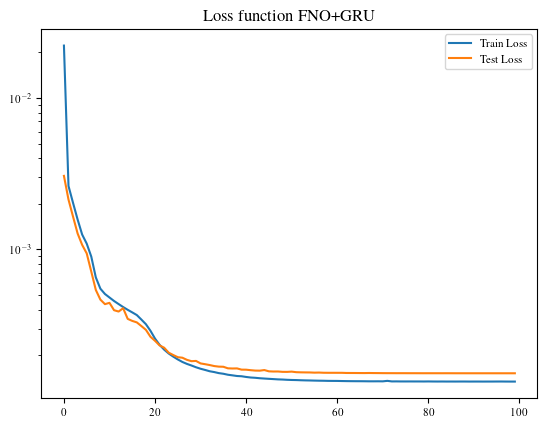

Final Testing Loss: 0.00015182545954187858
Final Training Loss: 0.00013381711375439742


<Figure size 640x480 with 0 Axes>

In [47]:
# Train fno_gru
fno_gru, fno_gru_train_loss_arr, fno_gru_test_loss_arr = model_trainer(fno_gru, trainData, testData, \
                                                         fno_gru_config.epochs, sim_config.batch_size, \
                                                         fno_gru_config.gamma, fno_gru_config.learning_rate,\
                                                         fno_gru_config.weight_decay, \
                                                         "../models/UnicycleConstDelayModels/fnogru")
evaluate_train_performance(fno_gru, fno_gru_config.model_type, fno_gru_train_loss_arr, fno_gru_test_loss_arr)

In [48]:
# # Train deeponet_gru
# deeponet_gru, deeponet_gru_train_loss_arr, deeponet_gru_test_loss_arr = model_trainer(deeponet_gru, trainData, testData, \
#                                                           deeponet_gru_config.epochs, sim_config.batch_size, \
#                                                           deeponet_gru_config.gamma, deeponet_gru_config.learning_rate,\
#                                                           deeponet_gru_config.weight_decay, \
#                                                            "../models/UnicycleConstDelayModels/deeponetgru")
# evaluate_train_performance(deeponet_gru, deeponet_gru_config.model_type, deeponet_gru_train_loss_arr, deeponet_gru_test_loss_arr)

### Load our trained models
Either load the pretrained models on hugging face or the trained models from the previous cells. 

In [11]:
# Load models, note the incompatible keys is due to the NeuralOperator package and torch load. This can be ignored. 

fno.load_state_dict(torch.load("../models/UnicycleConstDelayModels/" + fno_config.model_filename, weights_only=False), strict=False)
deeponet.load_state_dict(torch.load("../models/UnicycleConstDelayModels/" + deeponet_config.model_filename, weights_only=True))
fno_gru.load_state_dict(torch.load("../models/UnicycleConstDelayModels/" + fno_gru_config.model_filename, weights_only=False), strict=False)
deeponet_gru.load_state_dict(torch.load("../models/UnicycleConstDelayModels/" + deeponet_gru_config.model_filename, weights_only=True), strict=False)

<All keys matched successfully>

### Evaluate our trained models
This is split into three parts:
 - Evaluate our trained models over the dataset (make sure you load the dataset above first)
 - 25 random trajectories
 - Computational time

In [12]:
fno_train_error, fno_test_error = evaluate_model(fno, fno_config.model_type, trainData, testData)
deeponet_train_error, deeponet_test_error = evaluate_model(deeponet, deeponet_config.model_type, trainData, testData)
fno_gru_train_error, fno_gru_test_error = evaluate_model(fno_gru, fno_gru_config.model_type, trainData, testData)
deeponet_gru_train_error, deeponet_gru_test_error = evaluate_model(deeponet_gru, deeponet_gru_config.model_type, trainData, testData)

In [13]:
model_names = ["FNO", "DeepONet", "FNO+GRU", "DeepONet+GRU"]
train_losses = [fno_train_error, deeponet_train_error, fno_gru_train_error, deeponet_gru_train_error]
test_losses = [fno_test_error, deeponet_test_error, fno_gru_test_error, deeponet_gru_test_error]

# Header
print(f"{'Model':<15} {'Train Loss':<12} {'Test Loss':<10}")
print("-" * 39)

# Rows
for model, train, test in zip(model_names, train_losses, test_losses):
    print(f"{model:<15} {train:<12.6f} {test:<10.6f}")

Model           Train Loss   Test Loss 
---------------------------------------
FNO             0.000043     0.000065  
DeepONet        0.000063     0.000084  
FNO+GRU         0.000134     0.000152  
DeepONet+GRU    0.000076     0.000096  


#### Evaluate over 25 trajectories
This may take some time to evaluate. Choose a value < 25 for faster performance. 

In [14]:
def sim_trajectories(num_trajs, init_cond_randomization_variance, delay_randomization_variance, model, predictor_func, sim_config, verbose=True):
    best_prediction_error = np.inf
    worst_prediction_error = 0
    best_prediction_ic = None
    worst_prediction_ic = None
    best_delay = None
    worst_delay = None
    prediction_error_arr = []
    np.random.seed(sim_config.random_state)
    for i in range(num_trajs):
        init_cond = np.array([1, 1, 1]) + np.random.uniform(-init_cond_randomization_variance, init_cond_randomization_variance, size=3)
        D = np.random.uniform(1, 1+delay_randomization_variance)
        u_delay, control_delay, pde, predictors = simulate_system_const_delay(init_cond, sim_config.dt, sim_config.T, sim_config.dx, D,predictor_func, model)
        prediction_error = np.mean(np.linalg.norm(predictors[0:-sim_config.nD+2, -1]-u_delay[sim_config.nD-2:], axis=1))
        prediction_error_arr.append(prediction_error)
        if prediction_error < best_prediction_error:
            best_prediction_ic = init_cond
            best_prediction_error = prediction_error
            best_delay = D
        if prediction_error > worst_prediction_error:
            worst_prediction_ic = init_cond
            worst_prediction_error = prediction_error
            worst_delay = D
    avg_prediction_error = np.mean(np.array(prediction_error_arr))
    return best_prediction_ic, best_delay, worst_prediction_ic, worst_delay, avg_prediction_error

In [17]:
# FNO
best_ic_fno, best_delay_fno, worst_ic_fno, worst_delay_fno, prediction_error_fno = \
    sim_trajectories(25, 0.1, 0.1, fno, ml_predictor, sim_config, True)

In [22]:
# deeponet
best_ic_deeponet, best_delay_deeponet, worst_ic_deeponet, worst_delay_deeponet, prediction_error_deeponet = \
    sim_trajectories(25, 0.1, 0.1, deeponet, ml_predictor, sim_config, True)

In [23]:
# fnogru
best_ic_fno_gru, best_delay_fno_gru, worst_ic_fno_gru, worst_delay_fno_gru, prediction_error_fno_gru = \
    sim_trajectories(25, 0.1, 0.1, fno_gru, ml_predictor, sim_config, True)

In [24]:
# deeponet_gru
best_ic_deeponet_gru, best_delay_deeponet_gru, worst_ic_deeponet_gru, worst_delay_deeponet_gru, prediction_error_deeponet_gru = \
    sim_trajectories(25, 0.1, 0.1, deeponet_gru, ml_predictor, sim_config, True)

In [25]:
# numerical
_, _, _, _, prediction_error_numerical = \
    sim_trajectories(25, 0.1, 0.1, None, None, sim_config, True)

In [26]:
model_names = ["FNO", "DeepONet", "FNO+GRU", "DeepONet+GRU", "Numerical"]
prediction_errors = [prediction_error_fno, prediction_error_deeponet, prediction_error_fno_gru,\
                     prediction_error_deeponet_gru, prediction_error_numerical]

# Header
print(f"{'Model':<15} {'Avg. Prediction Error':<20}")
print("-" * 65)

# Rows
for model, error in zip(model_names, prediction_errors):
    print(f"{model:<15} {error:<20.6f}")

Model           Avg. Prediction Error
-----------------------------------------------------------------
FNO             0.061734            
DeepONet        0.058748            
FNO+GRU         0.268882            
DeepONet+GRU    0.156749            
Numerical       0.028543            


#### FNO Qualatative plots

In [18]:
# Simulate FNO best case example
fno_best_states, fno_best_controls, _, fno_best_predictors = \
simulate_system_const_delay(best_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, best_delay_fno, ml_predictor, fno)
numerical_best_states, numerical_best_controls, _, numerical_best_predictors  = \
simulate_system_const_delay(best_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, best_delay_fno)

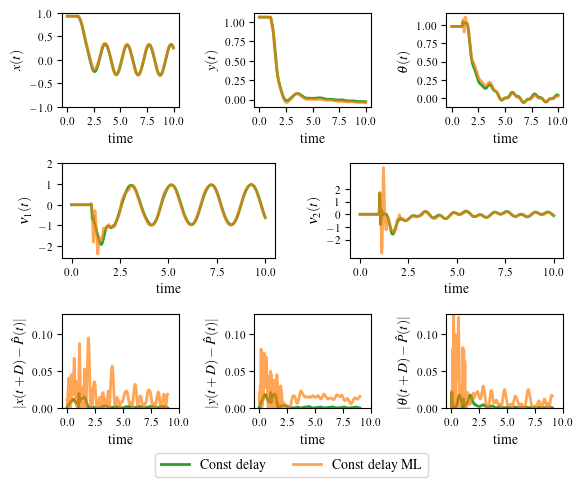

In [19]:
# Plot FNO Best Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_best_states,  fno_best_states, \
                            numerical_best_controls, fno_best_controls, \
                            numerical_best_predictors, fno_best_predictors,\
                            sim_config.nD, None)

In [20]:
# Simulate FNO worst case example
fno_worst_states, fno_worst_controls, _, fno_worst_predictors = \
simulate_system_const_delay(worst_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_fno, ml_predictor, fno)
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors  = \
simulate_system_const_delay(worst_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_fno)

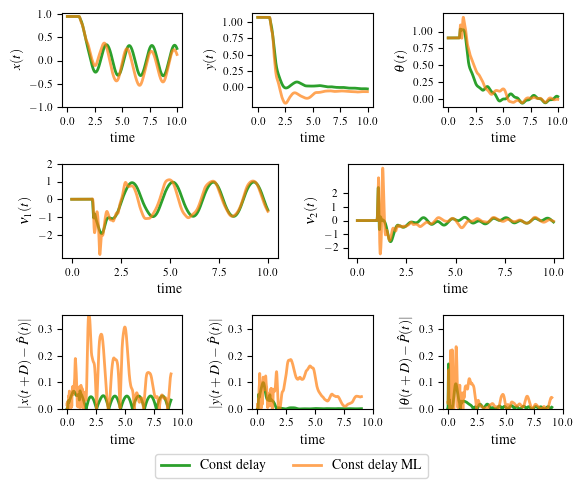

In [21]:
# Plot FNO worst Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_worst_states,  fno_worst_states, numerical_worst_controls, fno_worst_controls,\
                            numerical_worst_predictors, fno_worst_predictors, sim_config.nD)

#### DeepONet Qualatative plots

In [27]:
# Simulate deeponet best case example
deeponet_best_states, deeponet_best_controls, _, deeponet_best_predictors = \
simulate_system_const_delay(best_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, best_delay_deeponet, ml_predictor, deeponet)
numerical_best_states, numerical_best_controls, _, numerical_best_predictors  = \
simulate_system_const_delay(best_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, best_delay_deeponet)

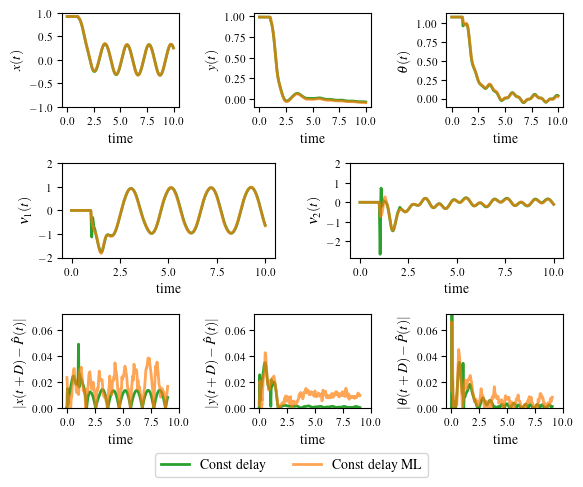

In [28]:
# Plot deeponet Best Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_best_states,  deeponet_best_states, \
                            numerical_best_controls, deeponet_best_controls, \
                            numerical_best_predictors, deeponet_best_predictors,\
                            sim_config.nD, None)

In [29]:
# Simulate deeponet worst case example
deeponet_worst_states, deeponet_worst_controls, _, deeponet_worst_predictors = \
simulate_system_const_delay(worst_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_deeponet, ml_predictor, deeponet)
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors  = \
simulate_system_const_delay(worst_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_deeponet)

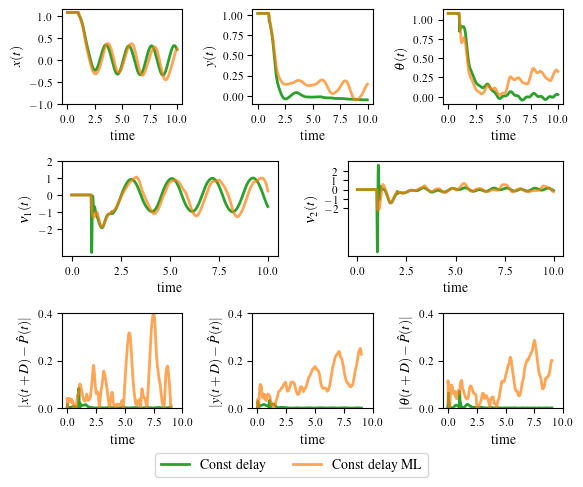

In [30]:
# Plot deeponet worst Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_worst_states,  deeponet_worst_states, numerical_worst_controls, deeponet_worst_controls,\
                            numerical_worst_predictors, deeponet_worst_predictors, sim_config.nD)

#### FNO+GRU Qualatative plots

In [31]:
# Simulate fno_gru best case example
fno_gru_best_states, fno_gru_best_controls, _, fno_gru_best_predictors = \
simulate_system_const_delay(best_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, best_delay_fno_gru, ml_predictor, fno_gru)
numerical_best_states, numerical_best_controls, _, numerical_best_predictors  = \
simulate_system_const_delay(best_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, best_delay_fno_gru)

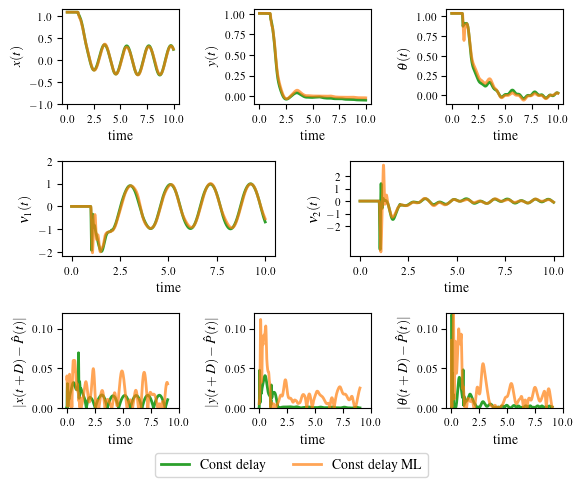

In [32]:
# Plot fno_gru Best Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_best_states,  fno_gru_best_states, \
                            numerical_best_controls, fno_gru_best_controls, \
                            numerical_best_predictors, fno_gru_best_predictors,\
                            sim_config.nD, None)

In [33]:
# Simulate fno_gru worst case example
fno_gru_worst_states, fno_gru_worst_controls, _, fno_gru_worst_predictors = \
simulate_system_const_delay(worst_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_fno_gru, ml_predictor, fno_gru)
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors  = \
simulate_system_const_delay(worst_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_fno_gru)

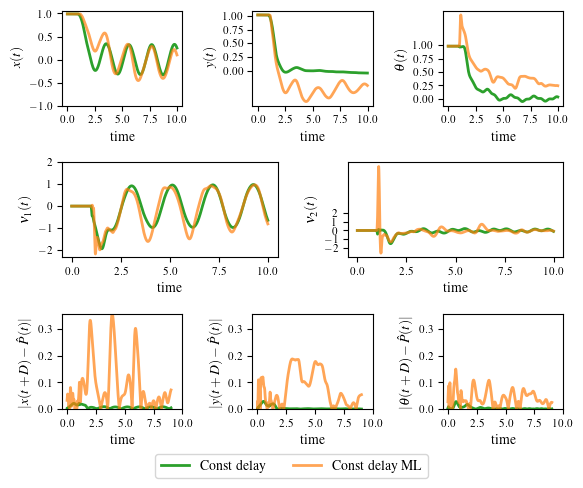

In [34]:
# Plot fno_gru worst Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_worst_states,  fno_gru_worst_states, numerical_worst_controls, fno_gru_worst_controls,\
                            numerical_worst_predictors, fno_gru_worst_predictors, sim_config.nD)

#### DeepONet+GRU Qualatative plots

In [35]:
# Simulate deeponet_gru best case example
deeponet_gru_best_states, deeponet_gru_best_controls, _, deeponet_gru_best_predictors = \
simulate_system_const_delay(best_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, best_delay_deeponet_gru, ml_predictor, deeponet_gru)
numerical_best_states, numerical_best_controls, _, numerical_best_predictors  = \
simulate_system_const_delay(best_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, best_delay_deeponet_gru)

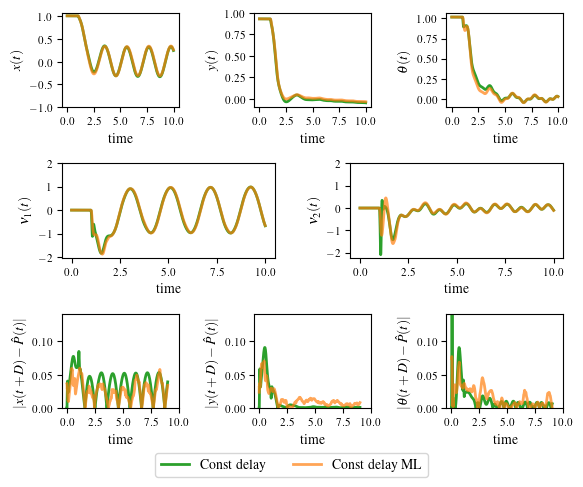

In [36]:
# Plot deeponet_gru Best Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_best_states,  deeponet_gru_best_states, \
                            numerical_best_controls, deeponet_gru_best_controls, \
                            numerical_best_predictors, deeponet_gru_best_predictors,\
                            sim_config.nD, None)

In [39]:
# Simulate deeponet_gru worst case example
deeponet_gru_worst_states, deeponet_gru_worst_controls, _, deeponet_gru_worst_predictors = \
simulate_system_const_delay(worst_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_deeponet_gru, ml_predictor, deeponet_gru)
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors  = \
simulate_system_const_delay(worst_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_deeponet_gru)

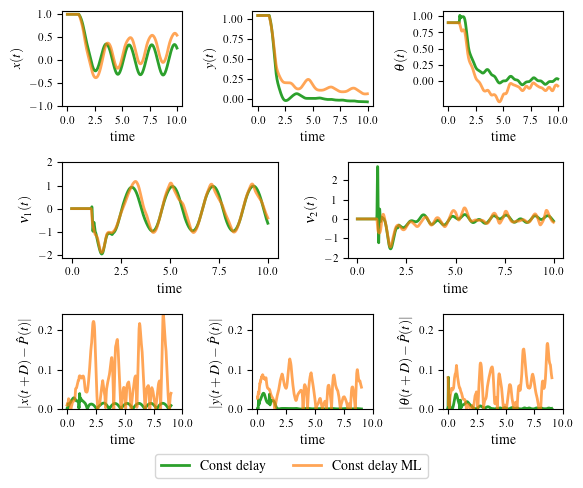

In [40]:
# Plot deeponet_gru worst Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_worst_states,  deeponet_gru_worst_states, numerical_worst_controls, deeponet_gru_worst_controls,\
                            numerical_worst_predictors, deeponet_gru_worst_predictors, sim_config.nD)

### Comparion of computation time for various discretizations 

In [123]:
names = ["numerical", "fno", "deeponet", "fnogru", "deeponetgru"]
time_steps = [0.01, 0.005, 0.001, 0.0005]
predictor_trials = 100

numerical_times = np.zeros(len(time_steps))
deeponet_times = np.zeros(len(time_steps))
fno_times = np.zeros(len(time_steps))
fno_gru_times = np.zeros(len(time_steps))
deeponet_gru_times = np.zeros(len(time_steps))

In [124]:
for i, dx in enumerate(time_steps):
    x = np.arange(0, 1, dx)
    nx = len(x)
    state = np.random.uniform(0, 1, size=3)
    control_history = np.random.uniform(0, 1, size=(nx, 2))
    D = 1

    # FNO - Use above config. 
    fno = FNOProjected(fno_config.hidden_size, fno_config.num_layers, fno_config.modes, fno_config.input_channel, fno_config.output_channel)

    # DeepONET - Need to update dt
    deeponet_grid = np.arange(0, sim_config.D, dx/6).astype(np.float32)
    deeponet_grid = torch.from_numpy(deeponet_grid.reshape((len(deeponet_grid), 1))).to(sim_config.device)
    deeponet_config.update_config(input_channel=deeponet_grid.shape[0], output_channel=nx*3)
    deeponet = DeepONetProjected(deeponet_config.dim_x, deeponet_config.hidden_size, deeponet_config.num_layers, \
                                deeponet_config.input_channel, deeponet_config.output_channel, \
                                deeponet_grid)

    # FNO+GRU - Use above config. 
    fno_gru_config.update_config(input_channel=6, output_channel=3)
    fno_gru = FNOGRUNet(fno_gru_config.fno_num_layers, fno_gru_config.gru_num_layers, fno_gru_config.fno_hidden_size, \
              fno_gru_config.gru_hidden_size, fno_gru_config.modes, fno_gru_config.input_channel, \
              fno_gru_config.output_channel)

    # DeepONET+GRU - Need to update dt
    deeponet_gru_grid = np.arange(0, sim_config.D, dx/6).astype(np.float32)
    deeponet_gru_grid = torch.from_numpy(deeponet_gru_grid.reshape((len(deeponet_gru_grid), 1))).to(sim_config.device)
    deeponet_gru_config.update_config(input_channel=deeponet_gru_grid.shape[0], output_channel=nx*3)
    deeponet_gru = DeepONetGRUNet(deeponet_gru_config.dim_x, deeponet_gru_config.deeponet_num_layers, deeponet_gru_config.gru_num_layers, \
                             deeponet_gru_config.deeponet_hidden_size, deeponet_gru_config.gru_hidden_size, deeponet_gru_config.input_channel, \
                             deeponet_gru_config.output_channel, deeponet_gru_grid)

    # Numerical Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        predictor_const_delay(state, control_history, D, x)
    end_time = time.time()
    numerical_times[i] = (end_time-start_time)/predictor_trials*1000

    # FNO Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        ml_predictor(state, control_history, D, x, fno)
    end_time = time.time()
    fno_times[i] = (end_time-start_time)/predictor_trials*1000

    # DeepONet Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        ml_predictor(state, control_history, D, x, deeponet)
    end_time = time.time()
    deeponet_times[i] = (end_time-start_time)/predictor_trials*1000

    
    # FNO+GRU Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        ml_predictor(state, control_history, D, x, fno_gru)
    end_time = time.time()
    fno_gru_times[i] = (end_time-start_time)/predictor_trials*1000

    # DeepONet+GRU Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        ml_predictor(state, control_history, D, x, deeponet_gru)
    end_time = time.time()
    deeponet_gru_times[i] = (end_time-start_time)/predictor_trials*1000
 

In [126]:
# Combine data into list of rows
rows = [
    ("Numerical", numerical_times),
    ("FNO", fno_times),
    ("DeepONet", deeponet_times),
    ("FNO-GRU", fno_gru_times),
    ("DeepONet-GRU", deeponet_gru_times)
]

# Print header
print("RAW CALCULATION TIMES (ms)")

header = f"{'Step size':>15}" + "".join([f"{ts:>12.4f}" for ts in time_steps])
print(header)
print("-" * len(header))

# Print each row
for name, values in rows:
    print(f"{name:>15}" + "".join([f"{v:12.4f}" for v in values]))

RAW CALCULATION TIMES (ms)
      Step size      0.0100      0.0050      0.0010      0.0005
---------------------------------------------------------------
      Numerical      2.0886      3.9878     21.8990     46.2658
            FNO      1.0627      0.9541      1.0264      0.9970
       DeepONet      0.3541      0.3182      1.2372      3.9317
        FNO-GRU      1.2395      1.2026      1.7693      2.4508
   DeepONet-GRU      0.5308      0.5752      1.8830      5.2402


In [128]:
# Combine data into list of rows
rows = [
    ("FNO", fno_times),
    ("DeepONet", deeponet_times),
    ("FNO-GRU", fno_gru_times),
    ("DeepONet-GRU", deeponet_gru_times)
]

# Print header
print("Speedup (numerical/ML_model)")

header = f"{'Step size':>15}" + "".join([f"{ts:>12.4f}" for ts in time_steps])
print(header)
print("-" * len(header))

# Print each row
for name, model_vals in rows:
    row = f"{name:>15}"
    for idx, val in enumerate(model_vals):
        num_time = numerical_times[idx]
        speedup = num_time / val if val != 0 else float('inf')
        row += f"{speedup:12.4f}"
    print(row)

Speedup (numerical/ML_model)
      Step size      0.0100      0.0050      0.0010      0.0005
---------------------------------------------------------------
            FNO      1.9655      4.1795     21.3363     46.4041
       DeepONet      5.8976     12.5309     17.6998     11.7675
        FNO-GRU      1.6851      3.3160     12.3771     18.8777
   DeepONet-GRU      3.9345      6.9335     11.6295      8.8291
